In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from utils import plot_clustering

In [2]:
# ## Read the data

data = pd.read_csv(
    "~/Documents/UTC/P24/SY09/Projet/projet_git/SY09_projet/spotify-2023.csv",
    encoding="latin-1",
)
data.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [3]:
relevant_columns = [
    "bpm",
    "streams",
    "danceability_%",
    "valence_%",
    "energy_%",
    "acousticness_%",
    "instrumentalness_%",
    "liveness_%",
    "speechiness_%",
    "mode",
]
df_relevant = data[relevant_columns].copy()

test_encoding = pd.DataFrame(data["artist(s)_name"])
test_encoding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   artist(s)_name  953 non-null    object
dtypes: object(1)
memory usage: 7.6+ KB


In [4]:
columns_name = pd.unique(test_encoding["artist(s)_name"])
new_columns_name = set()
for col in columns_name:
    if ',' in col:
        new_cols = col.split(', ')
        for new_col in new_cols:
            if new_col != '' and new_col not in new_columns_name:
                new_columns_name.add(new_col)
    else:
        if col not in new_columns_name:
            new_columns_name.add(col)

df_without_string = pd.DataFrame(False, index=[i for i in range(953)], columns=list(new_columns_name))

In [5]:
vals = []
for index, row in test_encoding.iterrows():
    new_vals = row["artist(s)_name"].split(', ')
    for new_val in new_vals:
        if new_val != '':
            df_without_string.at[index, new_val] = True

In [6]:
df_knn = pd.concat([df_relevant, df_without_string], axis=1)

In [7]:
df_knn.loc[:, "mode"] = [0 if x == "Minor" else 1 for x in data["mode"]]
df_knn["streams"] = pd.to_numeric(df_knn["streams"], errors="coerce")
df_knn["mode"] = pd.to_numeric(
    df_knn["mode"], errors="coerce"
)
df_knn.dropna(inplace=True)

In [8]:
df_knn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Columns: 708 entries, bpm to Future
dtypes: bool(698), float64(1), int64(9)
memory usage: 730.7 KB


/tmp/ipykernel_90216/2471462791.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="streams_class", data=df_knn, palette="viridis")


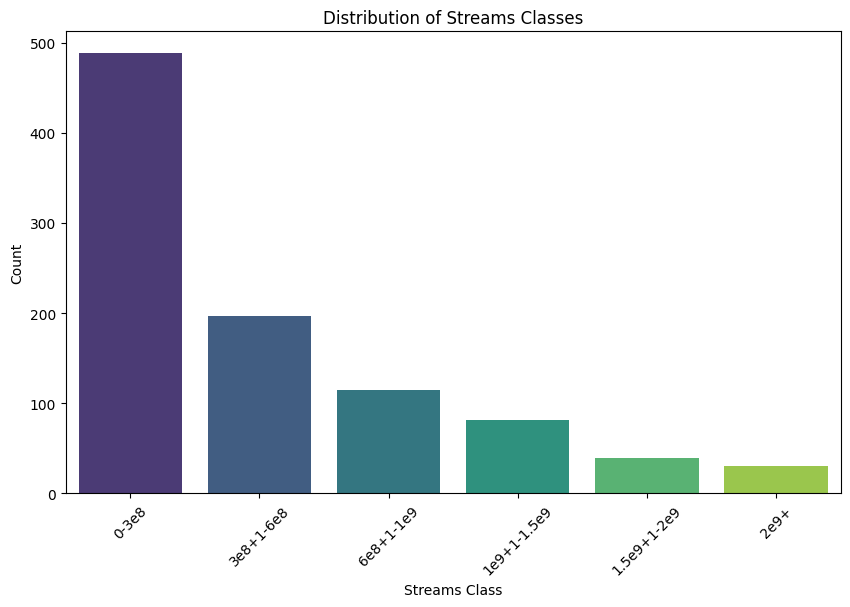

In [9]:
class_intervals = [
    (0, 3e8),
    (3e8+1, 6e8),
    (6e8+1, 1e9),
    (1e9+1, 1.5e9),
    (1.5e9+1, 2e9),
    (2e9+1, float("inf")),
]
class_labels = ["0-3e8", "3e8+1-6e8", "6e8+1-1e9", "1e9+1-1.5e9", "1.5e9+1-2e9", "2e9+"]

# Assign each bpm value to a class
df_knn["streams_class"] = pd.cut(
    df_knn["streams"],
    bins=[interval[0] for interval in class_intervals] + [float("inf")],
    labels=class_labels,
)
# Create the barplot
plt.figure(figsize=(10, 6))
sns.countplot(x="streams_class", data=df_knn, palette="viridis")
plt.xlabel("Streams Class")
plt.ylabel("Count")
plt.title("Distribution of Streams Classes")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# 121-140 max count

In [10]:
X = df_knn.iloc[:, :-1]
y = df_knn.iloc[:, -1]

In [11]:
# De 1 à 818 voisins (exclu), échelle logarithmique
n_neighbors_list = np.unique(np.round(np.geomspace(1, 953,100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}
cls = KNeighborsClassifier()
search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)
search.fit(X, y)
search.best_params_

/home/eliott/.virtualenvs/dev/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/eliott/.virtualenvs/dev/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/eliott/.virtualenvs/dev/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/eliott/.virtualenvs/dev/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/home/eliott/.virtualenvs/dev/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/home/eliott/.virtualenvs/dev/lib/pyth

{'n_neighbors': 5}

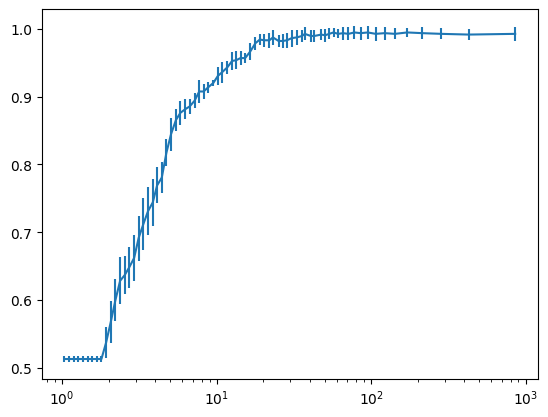

In [12]:
df = pd.DataFrame(
(
dict(n_neighbors=d["n_neighbors"], error=e, std=s)
for d, e, s in zip(
search.cv_results_["params"],
search.cv_results_["mean_test_score"],
search.cv_results_["std_test_score"],
)
)
)
n = 9/10 * len(y)
plt.errorbar(n/df["n_neighbors"], df["error"], yerr=df["std"])
plt.xscale("log")
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.66)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)
accuracy_score(y_pred, y_test)

/home/eliott/.virtualenvs/dev/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/eliott/.virtualenvs/dev/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/eliott/.virtualenvs/dev/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/eliott/.virtualenvs/dev/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/home/eliott/.virtualenvs/dev/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/home/eliott/.virtualenvs/dev/lib/pyth

0.9938271604938271

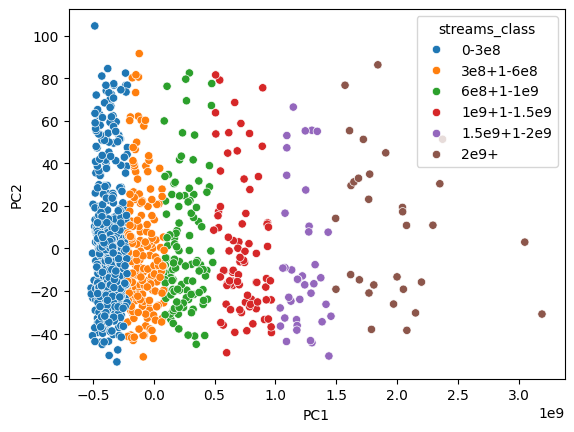

In [14]:
ax, pca = plot_clustering(X, y)